# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***PERCEIVED EMOTION DATA***

# **Goal 1: Long Form Analysis**
The initial Qualtrics data was pre-processed in a separate R script. For this part of the analysis, we will build on those dataframes and perform the following tasks:
1. Examination of Missing Data
2. Checking for Duplicates
3. Adding High-Level Summary Features
4. Looking at Mean Differences between Drug and Placebo
    * Overall means
    * Stimulus type (music, natural sounds, and speech)
    * Emotion type (positive, negative, neutral)
    * Arousal and valence levels
    
**We will do this separately for *induced* emotion data and *perceived* emotion data**

In [47]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix

# visualization tools
import matplotlib.pyplot as plt, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")

# only get warnings once
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%run Acetaminophen_Functions.ipynb

In [48]:
perceivedLong = pd.read_csv('cleaned_perceivedLong.csv')

### Comparing Means Between Drug/Placebo

In [49]:
# Change values for easy interpretation
perceivedLong['DrugPlacebo'].replace(0, "Placebo", inplace=True)
perceivedLong['DrugPlacebo'].replace(1, "Drug", inplace=True)

# Make arrays for t-tests
placebo = perceivedLong[perceivedLong['DrugPlacebo']=="Placebo"]
drug = perceivedLong[perceivedLong['DrugPlacebo']=="Drug"]

In [50]:
pos = perceivedLong.drop(columns=['Negative']).reset_index(drop=True)
pos.rename(columns={'Positive':'Rating'},inplace=True)

neg = perceivedLong.drop(columns=['Positive']).reset_index(drop=True)
neg.rename(columns={'Negative':'Rating'},inplace=True)
perceived = pos.append(neg, ignore_index=True)
perceived.dropna(subset=['Rating'], inplace=True)

print("Mean Ratings of Stimuli by Drug/Placebo Condition")
perceived.groupby(['DrugPlacebo'])['Rating'].agg(['mean', 'std']).round(3)

Mean Ratings of Stimuli by Drug/Placebo Condition


,mean,std
DrugPlacebo,,
Drug,3.625,3.429
Placebo,3.900,3.438


In [51]:
mixed_model = smf.mixedlm("Rating ~ DrugPlacebo", perceived, groups="FixedID")
mixed_model_results = mixed_model.fit()
mixed_model_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM   Dependent Variable:   Rating     
No. Observations:    16116     Method:               REML       
No. Groups:          237       Scale:                11.0165    
Min. group size:     68        Log-Likelihood:       -42412.5858
Max. group size:     68        Converged:            Yes        
Mean group size:     68.0                                       
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              3.625    0.088 41.071 0.000  3.452  3.798
DrugPlacebo[T.Placebo] 0.275    0.126  2.183 0.029  0.028  0.523
FixedID Var            0.780    0.026                           
================================================================

"""

## Positive and Negative Analysis

#### *Overall Means*
We examine the overall mean scores for *positive emotion ratings*, *negative emotion ratings*, and *arousal ratings* for participants who took the drug vs. participants who took the placebo.

**We then compare the means using t-tests.**

In [4]:
print("Mean Ratings of Pos/Neg Stimuli")
print("Positive mean:", "%.3f" % perceivedLong['Positive'].mean(), "std dev:", "%.3f" % perceivedLong['Positive'].std())
print("Negative mean:", "%.3f" % perceivedLong['Negative'].mean(), "std dev:", "%.3f" % perceivedLong['Negative'].std())

Mean Ratings of Pos/Neg Stimuli
Positive mean: 3.766 std dev: 3.462
Negative mean: 3.753 std dev: 3.410


In [5]:
# Positive Emotion Ratings
positive = perceivedLong[['FixedID', 'DrugPlacebo', 'Positive']]
positive = positive[positive['Positive'].notna()]

print("Perceived Emotion Overall Means -- Positive\n")
positive.groupby(['DrugPlacebo'])['Positive'].agg(['mean', 'std']).round(3)

# mixed_model = smf.mixedlm("Positive ~ DrugPlacebo", positive, groups="FixedID")
# mixed_model_results = mixed_model.fit()
# print(mixed_model_results.summary())

Perceived Emotion Overall Means -- Positive



,mean,std
DrugPlacebo,,
Drug,3.602,3.456
Placebo,3.936,3.462


In [6]:
# Negative Emotion Ratings
negative = perceivedLong[['FixedID', 'DrugPlacebo', 'Negative']]
negative = negative[negative['Negative'].notna()]

print("Perceived Emotion Overall Means -- Negative")
negative.groupby(['DrugPlacebo'])['Negative'].agg(['mean', 'std']).round(3)

# mixed_model = smf.mixedlm("Negative ~ DrugPlacebo", negative, groups="FixedID")
# mixed_model_results = mixed_model.fit()
# print(mixed_model_results.summary())

Perceived Emotion Overall Means -- Negative


,mean,std
DrugPlacebo,,
Drug,3.647,3.403
Placebo,3.864,3.415


In [7]:
# Arousal Ratings
arousal = perceivedLong[['FixedID', 'DrugPlacebo', 'Arousal']]
arousal = arousal[arousal['Arousal'].notna()]

print("Perceived Emotion Overall Means -- Arousal")
arousal.groupby(['DrugPlacebo'])['Arousal'].agg(['mean', 'std']).round(3)

# mixed_model = smf.mixedlm("Arousal ~ DrugPlacebo", arousal, groups="FixedID")
# mixed_model_results = mixed_model.fit()
# print(mixed_model_results.summary())

Perceived Emotion Overall Means -- Arousal


,mean,std
DrugPlacebo,,
Drug,4.326,3.191
Placebo,4.401,3.125


#### ***Conclusion:***
#### **When testing only the main effect of drug vs. placebo in a Mixed Linear Model (with ID as the group variable), the results are consistent with the hypothesis that, compared to a placebo, acetaminophen blunts people’s perception of positive  emotions in sound stimuli. For this main effect model, the results of drug/placebo on negative emotions were not statistically significant, but were trending in the right direction.**

#### **The results are *not* consistent with the hypothesis that, compared to a placebo, acetaminophen blunts people’s perception of arousal in sound stimuli.**


# *Stimulus Type (Music, Speech, Natural Sounds)*
We can examine to see whether the blunting effect of acetaminophen on perceived emotions is similar across different stimulus types.

We will *not* conduct t-tests on this data in order to prevent any potential problems of multiple tests.

In [8]:
# Positive Emotion Ratings
print("Perceived Emotion Stimulus Type -- Positive")
perceivedLong.groupby(['DrugPlacebo', 'SoundType'])['Positive'].agg(['mean', 'std']).round(3)


Perceived Emotion Stimulus Type -- Positive


mean    std
DrugPlacebo SoundType                   
Drug        Music           4.615  3.264
            Natural Sounds  3.439  3.802
            Speech          2.466  2.986
Placebo     Music           4.946  3.236
            Natural Sounds  3.647  3.746
            Speech          2.896  3.132

In [9]:
# Negative Emotion Ratings
print("Perceived Emotion Stimulus Type -- Negative")
perceivedLong.groupby(['DrugPlacebo', 'SoundType'])['Negative'].agg(['mean', 'std']).round(3)


Perceived Emotion Stimulus Type -- Negative


mean    std
DrugPlacebo SoundType                   
Drug        Music           3.179  3.093
            Natural Sounds  3.730  3.952
            Speech          4.167  3.203
Placebo     Music           3.393  3.161
            Natural Sounds  3.930  3.875
            Speech          4.405  3.240

In [10]:
# Arousal Ratings
print("Perceived Emotion Stimulus Type -- Arousal")
perceivedLong.groupby(['DrugPlacebo', 'SoundType'])['Arousal'].agg(['mean', 'std']).round(3)

Perceived Emotion Stimulus Type -- Arousal


mean    std
DrugPlacebo SoundType                   
Drug        Music           4.789  3.026
            Natural Sounds  4.652  3.405
            Speech          3.480  3.043
Placebo     Music           4.918  2.944
            Natural Sounds  4.687  3.305
            Speech          3.517  3.007

#### *Graph Stimulus Type:* **Positive**
A graph will help showcase the attentuating effect of acetaminophen on perceived positive emotions.

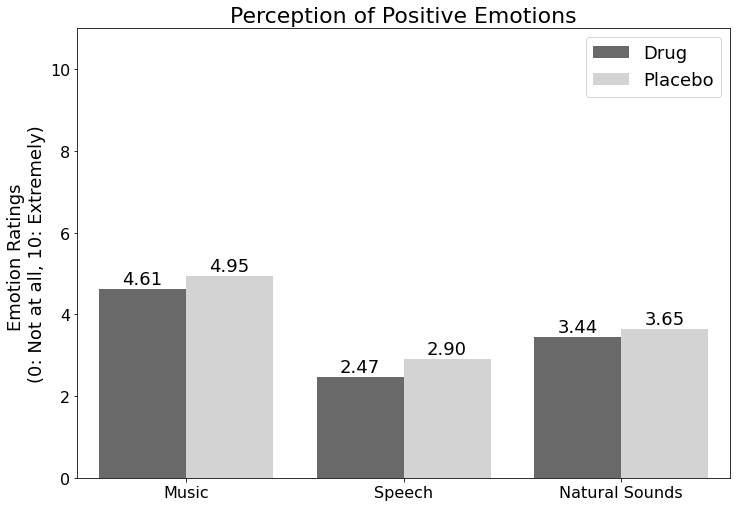

In [11]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Positive", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**The above graph shows that acetaminophen attenuated the perception of positive emotion similarly in music, natural sounds, and speech stimuli.**

#### *Graph Stimulus Type:* **Negative**
Now we can look at the attentuating effect of acetaminophen on perceived negative emotions.

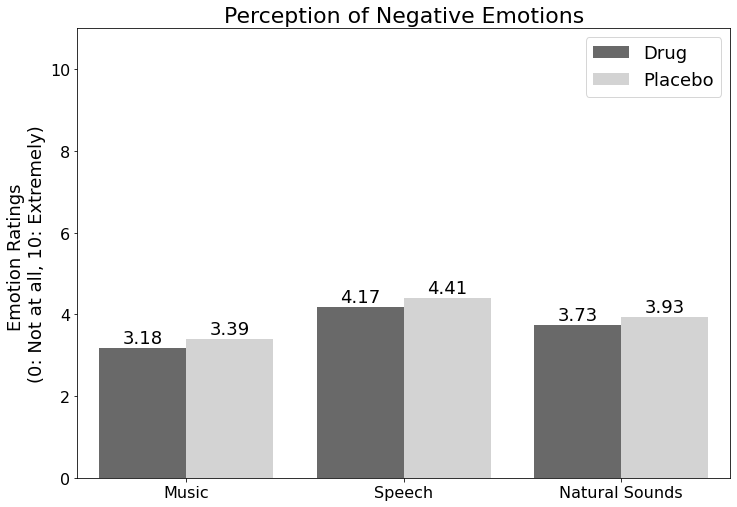

In [12]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Negative", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**The graph shows that acetaminophen also attenuated the perception of negative emotion similarly in music, natural sounds, and speech stimuli.**

**Comparing this graph to the graph above on positive emotions, we can see that the blunting effect of acetaminophen was similar across ratings of positive and negative emotions.**

#### *Graph Stimulus Type:* **Arousal**
Now we can look at the attentuating effect of acetaminophen on arousal ratings.

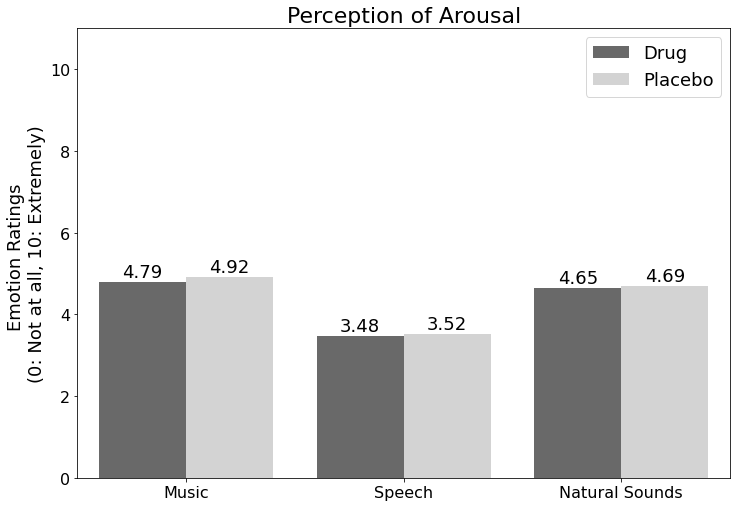

In [13]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Arousal", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**No real drug/placebo effect on arousal ratings.** 

# *Emotion Type (Positive, Negative, Neutral)*
Now we check whether acetaminophen blunts perceived emotion ratings for positive stimuli, negative stimuli, and netural stimuli.

In [14]:
# # Positive Emotion Ratings
# print("Perceived Emotion Emotion Type -- Positive")
# print(perceivedLong.groupby(['DrugPlacebo', 'PosNeg'])['Positive'].agg(['mean', 'std']).round(3), "\n")
        
# # Negative Emotion Ratings
# print("Perceived Emotion Emotion Type -- Negative")
# print(perceivedLong.groupby(['DrugPlacebo', 'PosNeg'])['Negative'].agg(['mean', 'std']).round(3), "\n")
        
# # Arousal Ratings
# print("Perceived Emotion Emotion Type -- Arousal")
# print(perceivedLong.groupby(['DrugPlacebo', 'PosNeg'])['Arousal'].agg(['mean', 'std']).round(3))

## *Circumplex Type (Arousal and Valence Info)*
We can look to see whether the drug attenuation affects perceived emotion ratings for different types of emotional stimuli:
* Negative Valence, High Arousal
* Negative Valence, Low Arousal
* Neutral
* Positive Valence, Low Arousal
* Positive Valence, High Arousal


In [15]:
# Positive Emotion Ratings
print("Perceived Emotion Circumplex -- Positive")
perceivedLong.groupby(['DrugPlacebo', 'Russell'])['Positive'].agg(['mean', 'std']).round(3)


Perceived Emotion Circumplex -- Positive


mean    std
DrugPlacebo Russell                               
Drug        Neg-Valence High-Arousal  1.084  1.692
            Neg-Valence Low-Arousal   1.609  2.208
            Neutral                   1.871  2.301
            Pos-Valence High-Arousal  7.186  2.762
            Pos-Valence Low-Arousal   5.549  2.774
Placebo     Neg-Valence High-Arousal  1.338  1.918
            Neg-Valence Low-Arousal   1.967  2.455
            Neutral                   2.330  2.396
            Pos-Valence High-Arousal  7.552  2.498
            Pos-Valence Low-Arousal   5.896  2.610

In [16]:
# Negative Emotion Ratings
print("Perceived Emotion Circumplex -- Negative")    
perceivedLong.groupby(['DrugPlacebo', 'Russell'])['Negative'].agg(['mean', 'std']).round(3)

Perceived Emotion Circumplex -- Negative


mean    std
DrugPlacebo Russell                               
Drug        Neg-Valence High-Arousal  6.776  2.718
            Neg-Valence Low-Arousal   5.690  2.907
            Neutral                   2.683  2.679
            Pos-Valence High-Arousal  1.068  1.908
            Pos-Valence Low-Arousal   1.730  2.199
Placebo     Neg-Valence High-Arousal  6.932  2.644
            Neg-Valence Low-Arousal   5.939  2.979
            Neutral                   3.034  2.719
            Pos-Valence High-Arousal  1.195  1.901
            Pos-Valence Low-Arousal   1.893  2.168

In [17]:
# Arousal Ratings
print("Perceived Emotion Circumplex -- Arousal")        
perceivedLong.groupby(['DrugPlacebo', 'Russell'])['Arousal'].agg(['mean', 'std']).round(3)

Perceived Emotion Circumplex -- Arousal


mean    std
DrugPlacebo Russell                               
Drug        Neg-Valence High-Arousal  5.540  3.001
            Neg-Valence Low-Arousal   3.248  2.900
            Neutral                   1.721  2.153
            Pos-Valence High-Arousal  6.679  2.665
            Pos-Valence Low-Arousal   3.475  2.566
Placebo     Neg-Valence High-Arousal  5.456  2.937
            Neg-Valence Low-Arousal   3.320  2.910
            Neutral                   1.755  2.094
            Pos-Valence High-Arousal  6.753  2.563
            Pos-Valence Low-Arousal   3.739  2.497

#### *Graph Circumplex:* **Positive**
Once again, a graph will help visualize this effect.

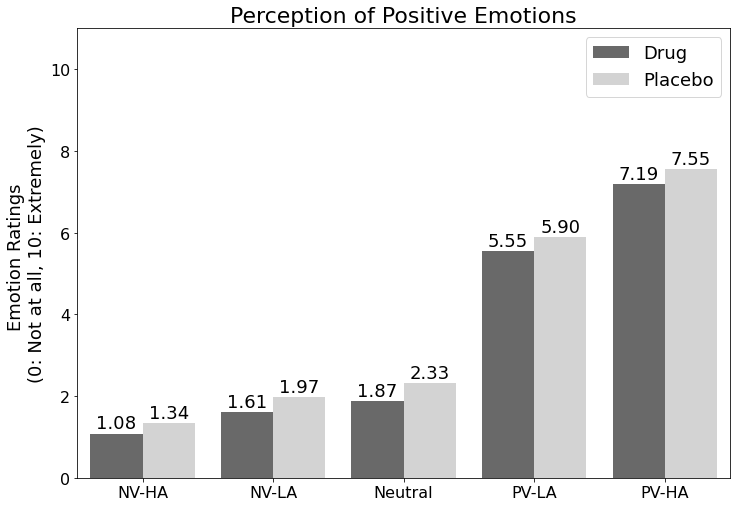

In [18]:
# change labels for easy interpretation
perceivedLong['Russell'].replace("Neg-Valence High-Arousal", "NV-HA", inplace=True)
perceivedLong['Russell'].replace("Pos-Valence High-Arousal", "PV-HA", inplace=True)
perceivedLong['Russell'].replace("Neg-Valence Low-Arousal", "NV-LA", inplace=True)
perceivedLong['Russell'].replace("Pos-Valence Low-Arousal", "PV-LA", inplace=True)

# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Positive", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**Acetaminophen attenuated the perception of positive emotion similarly in stimuli classified as *negative valence-high arousal*, *negative valence-low arousal*, *neutral*, *positive valence-low arousal*, and *positive valence-high arousal*.**

#### *Graph Circumplex:* **Negative**
And our last graph.

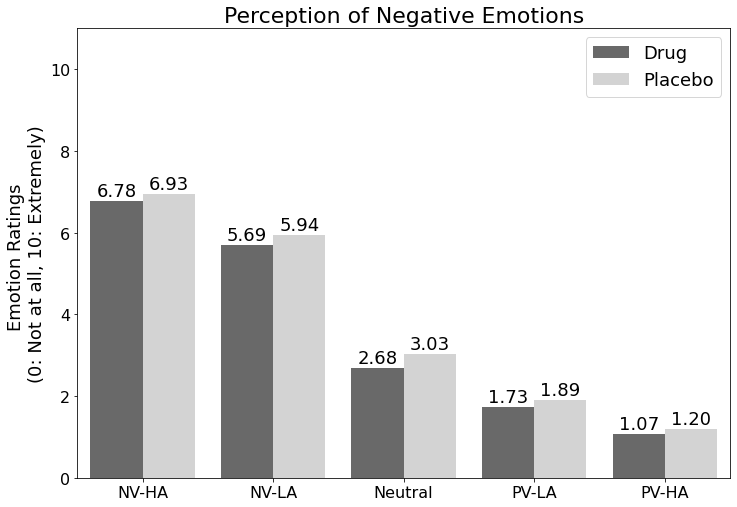

In [19]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Negative", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**The above graph shows, once again, that acetaminophen blunts the perception of negative emotion similarly in stimuli classified as *negative valence-high arousal*, *negative valence-low arousal*, *neutral*, *positive valence-low arousal*, and *positive valence-high arousal*.**

**Furthermore, the attenuating effect of acetaminophen was similar across ratings of positive and negative perceived emotions.**

#### *Graph Circumplex:* **Arousal**
Once again, a graph will help visualize this effect.

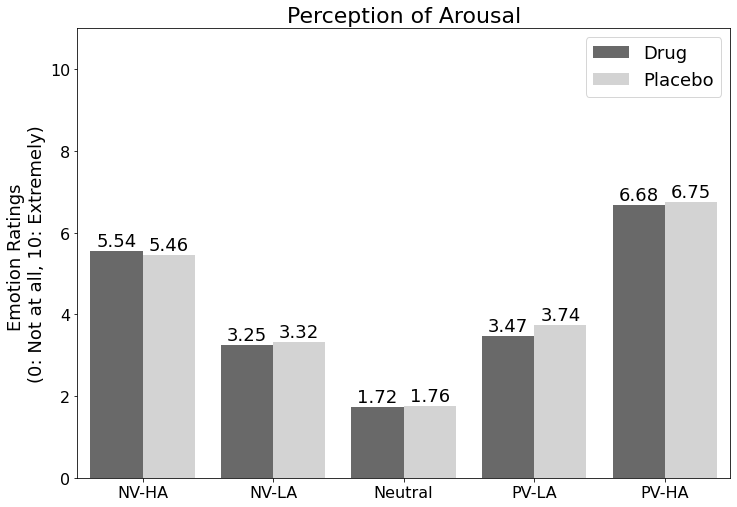

In [20]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Arousal", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**No real drug/placebo effect on arousal ratings.** 

# **Plot perceived emotions by sound type**

In [21]:
music = perceivedLong[perceivedLong['SoundType'] == "Music"]
natural = perceivedLong[perceivedLong['SoundType'] == "Natural Sounds"]
speech = perceivedLong[perceivedLong['SoundType'] == "Speech"]

## *Music*

In [22]:
musicEmotions = [
    (music['Stimulus'].str.contains('Tender', regex=True) == True),
    (music['Stimulus'].str.contains('Sad', regex=True) == True),
    (music['Stimulus'].str.contains('Happy', regex=True) == True),
    (music['Stimulus'].str.contains('Fear', regex=True) == True)]
choices = ['Tender', 'Sad', 'Happy', 'Fear']
music['Stimulus'] = np.select(musicEmotions, choices)

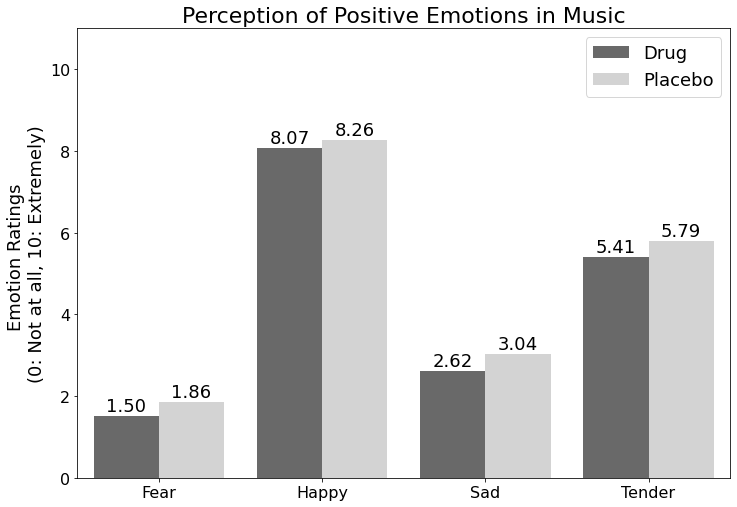

In [23]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

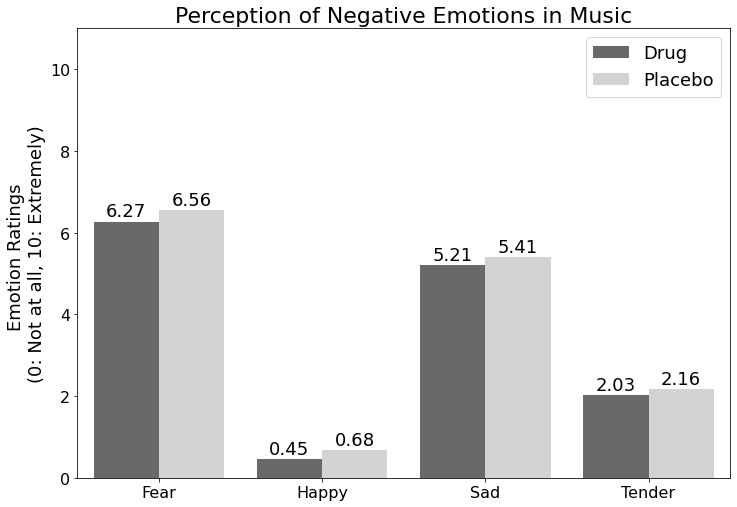

In [24]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

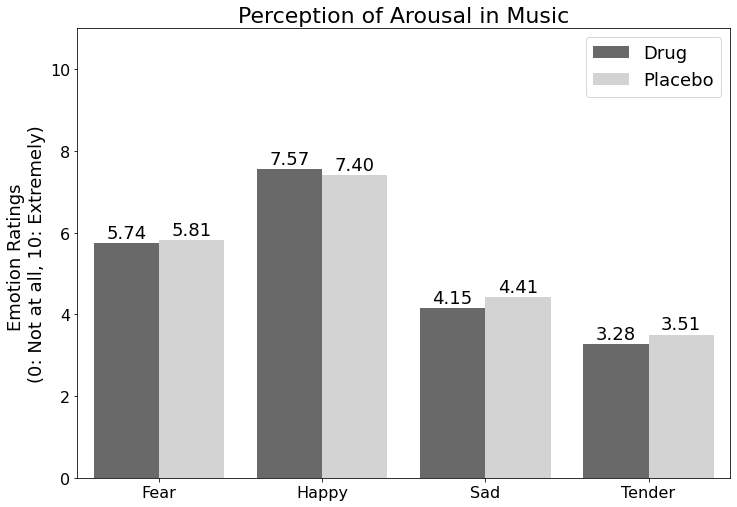

In [25]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Arousal", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Speech*

In [26]:
speechEmotions = [
    (speech['Stimulus'].str.contains('Neutral', regex=True) == True),
    (speech['Stimulus'].str.contains('Sad', regex=True) == True),
    (speech['Stimulus'].str.contains('Happy', regex=True) == True),
    (speech['Stimulus'].str.contains('Fear', regex=True) == True)]
choices = ['Neutral', 'Sad', 'Happy', 'Fear']
speech['Stimulus'] = np.select(speechEmotions, choices)

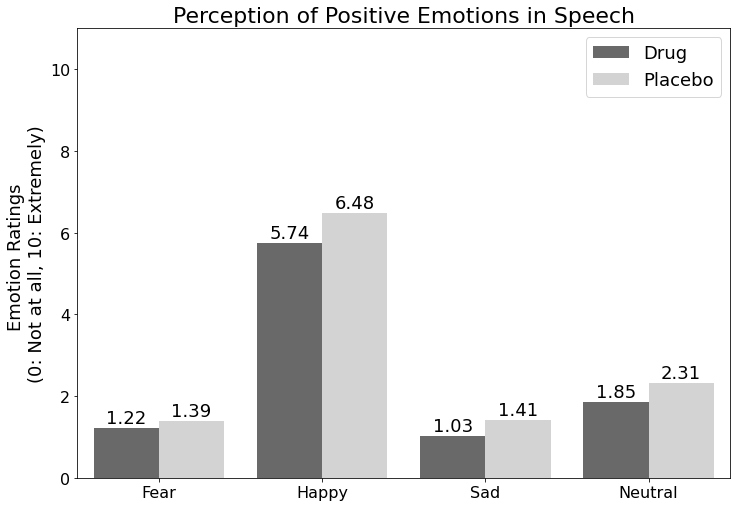

In [27]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=speech, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Speech', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

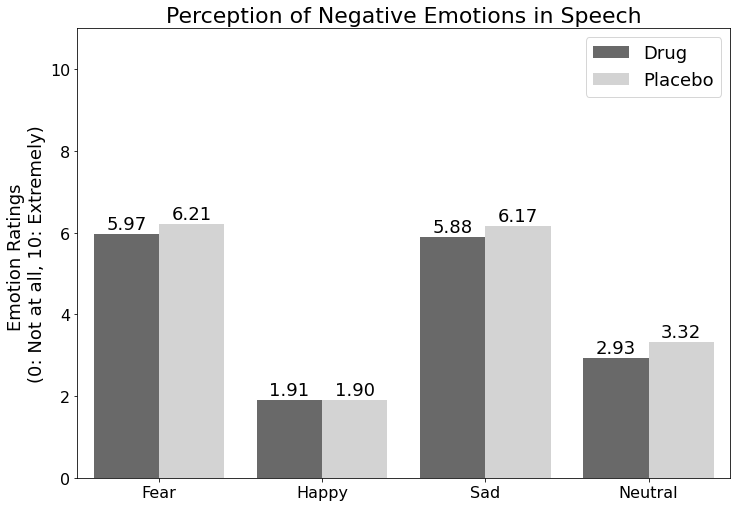

In [28]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=speech, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Speech', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

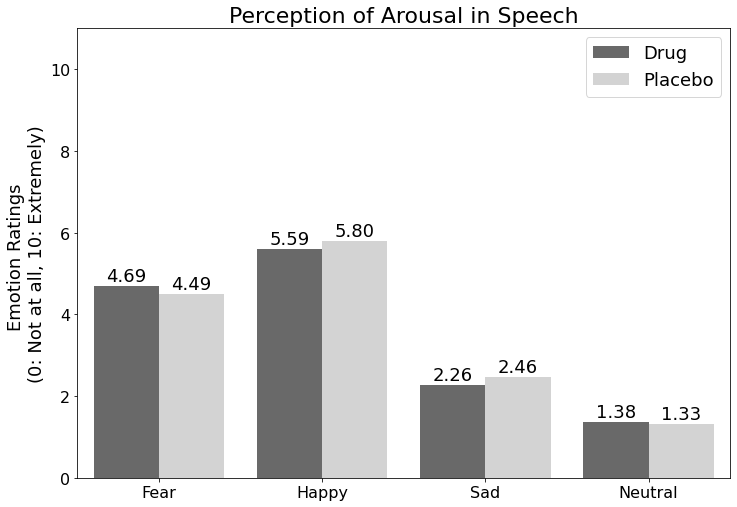

In [29]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Arousal", hue="DrugPlacebo", data=speech, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Speech', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Human*

In [30]:
human = natural[natural['Stimulus'].isin(['Neutral Human', 
                                             'Negative-Valence High-Arousal Human', 
                                             'Negative-Valence Low-Arousal Human', 
                                             'Positive-Valence High-Arousal Human', 
                                             'Positive-Valence Low-Arousal Human'])]

human['Stimulus'].replace("Neutral Human", "Neutral", inplace=True)
human['Stimulus'].replace("Negative-Valence High-Arousal Human", "NV-HA", inplace=True)
human['Stimulus'].replace("Negative-Valence Low-Arousal Human", "NV-LA", inplace=True)
human['Stimulus'].replace("Positive-Valence High-Arousal Human", "PV-HA", inplace=True)
human['Stimulus'].replace("Positive-Valence Low-Arousal Human", "PV-LA", inplace=True)

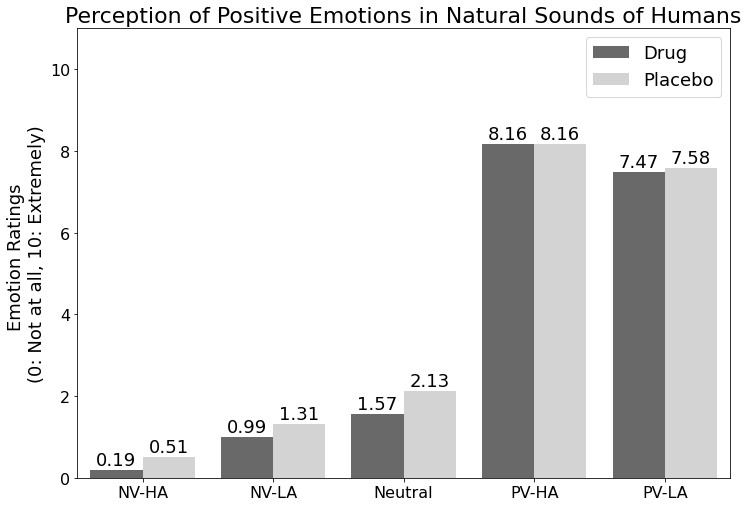

In [31]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

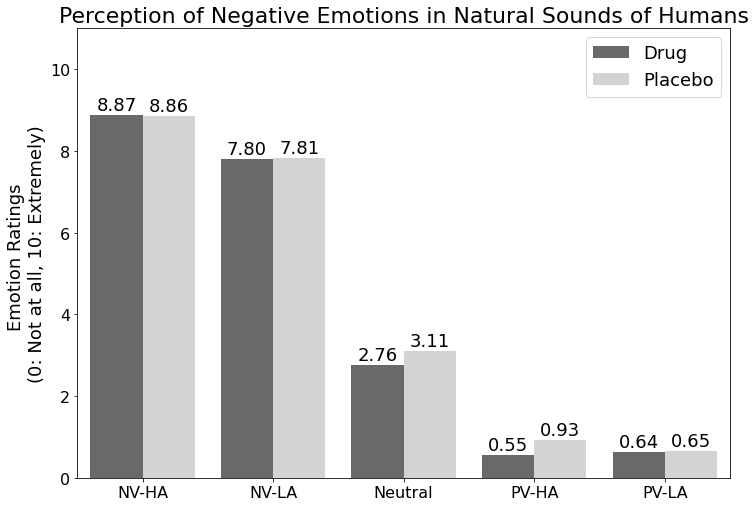

In [32]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

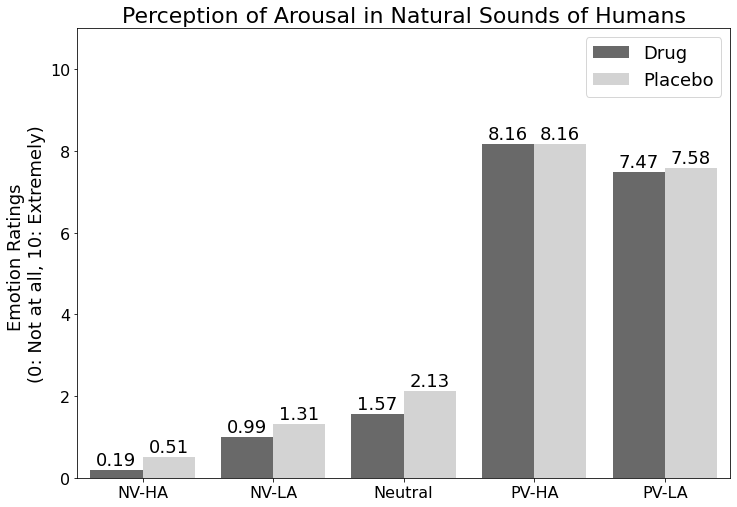

In [33]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Non-Human*

In [34]:
nonhuman = natural[natural['Stimulus'].isin(['Neutral Non-human', 
                                             'Negative-Valence High-Arousal Non-human', 
                                             'Negative-Valence Low-Arousal Non-human', 
                                             'Positive-Valence High-Arousal Non-human', 
                                             'Positive-Valence Low-Arousal Non-human'])]

nonhuman['Stimulus'].replace("Neutral Non-human", "Neutral", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence High-Arousal Non-human", "NV-HA", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence Low-Arousal Non-human", "NV-LA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence High-Arousal Non-human", "PV-HA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence Low-Arousal Non-human", "PV-LA", inplace=True)

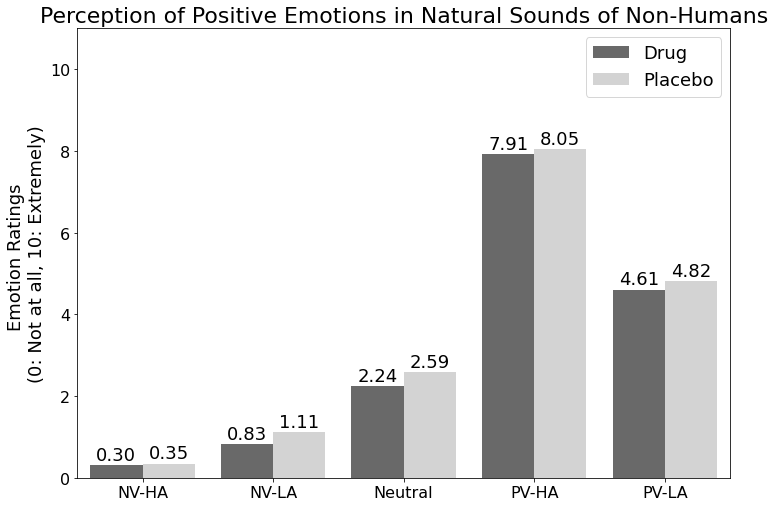

In [35]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

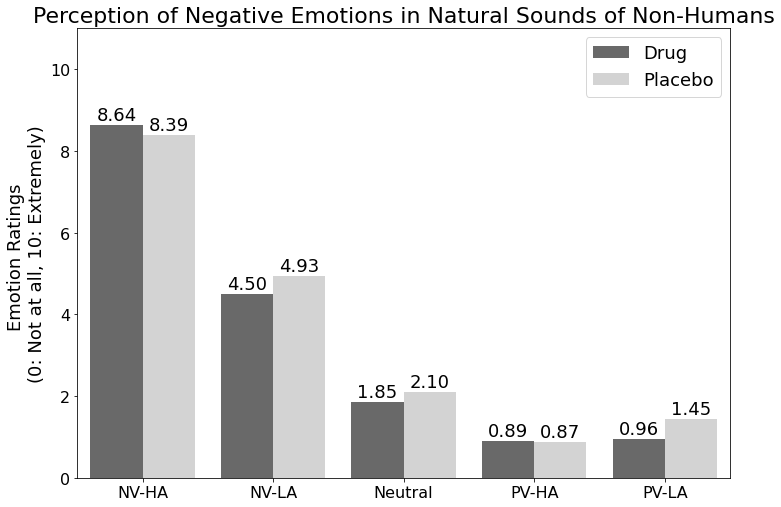

In [36]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

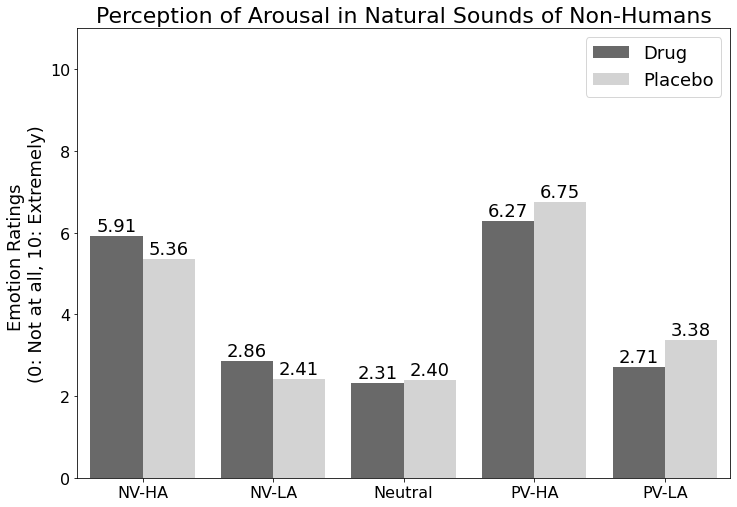

In [37]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Arousal", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

# Summary

In [38]:
# change columns back
perceivedLong['DrugPlacebo'].replace("Placebo", 0, inplace=True)
perceivedLong['DrugPlacebo'].replace("Drug", 1, inplace=True)
perceivedLong['Russell'].replace("NV-HA", "Neg-Valence High-Arousal", inplace=True)
perceivedLong['Russell'].replace("PV-HA", "Pos-Valence High-Arousal", inplace=True)
perceivedLong['Russell'].replace("NV-LA", "Neg-Valence Low-Arousal", inplace=True)
perceivedLong['Russell'].replace("PV-LA", "Pos-Valence Low-Arousal", inplace=True)

perceivedLong.head(1)

,FixedID,DrugCode,DrugPlacebo,Locus,Stimulus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,PosNeg,SoundType,Russell
0,8.0,8J,1,Perceived,Fear Music 1,NaN,NaN,NaN,NaN,0,Not Measured,0,0,0,0,0,0,0,Not Measured,Not Measured,Not Measured,Not Measured,0,0,Not Measured,0,Not Measured,0,Not Measured,Not Measured,Not Measured,0,Negative,Music,Neg-Valence High-Arousal
